# FeatureBased con todos los features (2015 a 2017)

In [1]:
import glob
from sklearn.preprocessing import MinMaxScaler
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import tsfeature as tsf
import sys
sys.path.append("../")

import pprint
from sklearn.decomposition import PCA
from kats.consts import TimeSeriesData
from statsmodels.tsa.seasonal import STL
from kats.utils.simulator import Simulator
from sklearn.preprocessing import StandardScaler
from kats.tsfeatures.tsfeatures import TsFeatures
from scipy.stats import entropy
from math import log, e
from sklearn.metrics import davies_bouldin_score

import warnings
warnings.simplefilter(action='ignore')

C:\ProgramData\Anaconda3\envs\kats\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
my_path = os.path.abspath('')
my_path = my_path.split('\\')
my_path_py = "\\".join(my_path[:-2])

df = pd.read_csv(my_path_py+'\\DatosRaw\\DEN_2015to2020.csv', sep=',')
df = df[df['Año']<2018]
df

,Dep-Prov-Distrito,Distrito,Semana,Incidencia semanal,Casos,pobtot,Año,Incidencia Calculada
0,"LAMBAYEQUE, LAMBAYEQUE, LAMBAYEQUE",LAMBAYEQUE,24,1.24886,1.0,77234,2015,1.294767
1,"LAMBAYEQUE, LAMBAYEQUE, LAMBAYEQUE",LAMBAYEQUE,27,1.24886,1.0,77234,2015,1.294767
2,"LAMBAYEQUE, LAMBAYEQUE, LAMBAYEQUE",LAMBAYEQUE,21,1.24886,1.0,77234,2015,1.294767
3,"LAMBAYEQUE, LAMBAYEQUE, LAMBAYEQUE",LAMBAYEQUE,53,0.00000,0.0,77234,2015,0.000000
4,"LAMBAYEQUE, LAMBAYEQUE, LAMBAYEQUE",LAMBAYEQUE,52,0.00000,0.0,77234,2015,0.000000
...,...,...,...,...,...,...,...,...
42819,"LORETO, LORETO, URARINAS",URARINAS,154,0.00000,0.0,14993,2017,0.000000
42820,"LORETO, LORETO, URARINAS",URARINAS,153,0.00000,0.0,14993,2017,0.000000
42821,"LORETO, LORETO, URARINAS",URARINAS,109,0.00000,0.0,14993,2017,0.000000
42822,"LORETO, LORETO, URARINAS",URARINAS,108,0.00000,0.0,14993,2017,0.000000


In [3]:
print("La cantidad de ciudades con datos es:", len(np.unique(df['Dep-Prov-Distrito'])))

i=0
listaDistrito = list(np.unique(df['Dep-Prov-Distrito']))
df1 = df[['Dep-Prov-Distrito','Semana', 'Incidencia semanal']]
for dis in listaDistrito:
    df1.loc[df1['Dep-Prov-Distrito']==dis,'ID_distrito']=i
    i=i+1
df1= df1.fillna(0.0000001)

La cantidad de ciudades con datos es: 396


In [4]:
def run_length_encoding(x):
    """
    :param x: np.array
    :return: np.array
    """
    pos, = np.where(np.diff(x) != 0)
    pos = np.concatenate(([0], pos+1, [len(x)]))
    # rle = [(a,b,x[a]) for (a,b) in zip(pos[:-1],pos[1:])]
    rle = [b - a for (a, b) in zip(pos[:-1], pos[1:])]
    return rle


def hysteresis(x, th_lo, th_hi, initial=False):
    """
    :param x: np.array
    :param th_lo: float
    :param th_hi: float
    :param initial: ???
    :return:
    """
    hi = x >= th_hi
    lo_or_hi = (x <= th_lo) | hi
    ind = np.nonzero(lo_or_hi)[0]
    # prevent index error if ind is empty
    if not ind.size:
        return np.zeros_like(x, dtype=bool) | initial
    # from 0 to len(x)
    cnt = np.cumsum(lo_or_hi)
    return np.where(cnt, hi[ind[cnt-1]], initial)


def arg_longest_not_null(x):
    # pad with np.nan while finding where null
    m = np.concatenate(( [True], np.isnan(x), [True] ))
    # Start-stop limits
    ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)
    # Get max interval, interval limits
    start, stop = ss[(ss[:,1] - ss[:,0]).argmax()]
    return start, stop

In [5]:
class poly(object):
    """ Orthogonal polynomials

    Source:
        http://davmre.github.io/python/2013/12/15/orthogonal_poly
    """

    def __init__(self):
        self.degree = None
        self.z = None
        self.norm2 = None
        self.alpha = None

    def fit(self, x, degree=1):

        self.degree = degree

        n = degree + 1
        x = np.asarray(x).flatten()
        if degree >= len(np.unique(x)):
            raise ValueError("'degree' must be less than number of unique points")

        xbar = np.mean(x)
        x = x - xbar
        q, r = np.linalg.qr(np.fliplr(np.vander(x, n)))

        z = np.diag(np.diag(r))
        raw = np.dot(q, z)

        norm2 = np.sum(raw**2, axis=0)
        alpha = (np.sum((raw**2)*np.reshape(x, (-1, 1)), axis=0)/norm2 + xbar)[:degree]
        z = raw / np.sqrt(norm2)

        self.z = z
        self.norm2 = norm2
        self.alpha = alpha

    def predict(self, x):
        x = np.asarray(x).flatten()
        n = self.degree + 1
        z = np.empty((len(x), n))
        z[:, 0] = 1

        if self.degree > 0:
            z[:, 1] = x - self.alpha[0]

        if self.degree > 1:
            for i in np.arange(1, self.degree):
                z[:, i+1] = (x - self.alpha[i]) * z[:, i] - (self.norm2[i] / self.norm2[i-1]) * z[:, i-1]

        z /= np.sqrt(self.norm2)

        return z

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale as scale_data


def biplot_features(x, robust=False, scale=True,  col=None, **kwargs):
    X = x.dropna(axis=1, how='all').dropna(axis=0, how='any')

    if col is None:
        col = ("#000000", "darkred")
    else:
        col = [col] if not isinstance(col, (list, tuple)) else col
        col = np.unique(col)

        if len(col) == 1:
            col = np.repeat(col, 2)
        else:
            col = np.unique(col)[0:2]

    if scale:
        X = scale_data(X, with_mean=True, with_std=True)

    if robust:
        raise NotImplemented('Robust PCA has not been implemented yet')
    else:
        pca = PCA(n_components=2)
        pca.fit(X)
        proj_pca = pca.transform(X)

    plt.figure()
    plt.scatter(x=proj_pca[:, 0], y=proj_pca[:, 1], c=col)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

In [7]:
import statsmodels.api as sm

from statsmodels.formula.api import ols
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.stats import boxcox_normmax
from statsmodels.sandbox.gam import AdditiveModel

try:
    from entropy import spectral_entropy
except ImportError:
    ENTROPY_PACKAGE_AVAILABLE = False
else:
    ENTROPY_PACKAGE_AVAILABLE = True

# features_hyndman
# https://github.com/robjhyndman/anomalous/blob/master/R/tsmeasures.R

_VARIABLE_COUNT = 0


def trim(x, trim=0.1):
    """Trimmed time series eliminating outliers's influence"""
    qtl = x.quantile([trim, 1 - trim])
    lo = qtl.iloc[0]
    hi = qtl.iloc[1]

    trim_x = x.copy()
    trim_x[(trim_x < lo) | (trim_x > hi)] = np.nan
    return trim_x


def first_order_autocorrelation(x):
    """First order of autocorrelation"""
    return x.autocorr(1)


def lumpiness(x, width):
    """Lumpiness

    Note:
        Cannot be used for yearly data
    """
    nr = len(x)
    start = np.arange(1, nr, step=width, dtype=int)
    end = np.arange(width, nr + width, step=width, dtype=int)

    nsegs = int(nr / width)

    varx = np.zeros(nsegs)

    for idx in range(nsegs):
        tmp = x[start[idx]:end[idx]]
        varx[idx] = tmp[~np.isnan(tmp)].var()

    lump = varx[~np.isnan(varx)].var()
    return lump


def rolling_level_shift(x, width):
    """Level shift

    Using rolling window
    """

    tmp = x.dropna()
    roll_mean = tmp.rolling(width).mean()

    try:
        level_shifts = roll_mean.diff(width).abs().max()
    except Exception:
        level_shifts = np.nan

    return level_shifts


def rolling_variance_change(x, width):
    """Variance change

    Using rolling window

    """
    tmp = x.dropna()

    roll_var = tmp.rolling(width).var()

    try:
        variance_change = roll_var.diff(width).abs().max()
    except Exception:
        variance_change = np.nan

    return variance_change


def n_crossing_points(x):
    """Number of crossing points"""
    mid_line = ((x.max() - x.min()) / 2.0)
    ab = (x <= mid_line).values
    len_x = len(x)
    p1 = ab[1:(len_x - 1)]
    p2 = ab[2:len_x]
    cross = (p1 & ~p2) | (p2 & ~p1)
    return cross.sum()


def flat_spots(x):
    """Flat spots using discretization"""

    try:
        cut_x = pd.cut(x, bins=10, include_lowest=True, labels=False)
        rle_x = run_length_encoding(cut_x)
        spots = max(rle_x)
    except Exception:
        spots = np.nan

    #  Any flat spot
    return spots


def trend_seasonality_spike_strength(x, freq):
    """Strength of trend and seasonality and spike"""
    cont_x = x.dropna()
    length_cont_x = len(cont_x)
    season = peak = trough = np.nan

    if length_cont_x < (2 * freq):
        trend = linearity = curvature = season = spike = peak = trough = np.nan
    else:

        if freq > 1:
            all_stl = sm.tsa.seasonal_decompose(cont_x, period=freq)
            trend0 = all_stl.trend
            fits = trend0 + all_stl.seasonal
            adj_x = cont_x - fits
            v_adj = adj_x.var()
            detrend = cont_x - trend0
            deseason = cont_x - all_stl.seasonal
            peak = all_stl.seasonal.max()
            trough = all_stl.seasonal.min()
            remainder = all_stl.resid
            season = 0 if detrend.var() < 1e-10 else max(0, min(1, 1 - v_adj/detrend.var()))

        else:  # No seasonal component
            tt = np.array([range(length_cont_x)]).T

            _trend0_values = AdditiveModel(tt).fit(cont_x.values).mu
            trend0=pd.Series(_trend0_values, index=cont_x.index)
            remainder = cont_x - trend0
            deseason = cont_x - trend0
            v_adj = trend0.var()

        trend = 0 if deseason.var() < 1e-10 else max(0, min(1, 1 - v_adj/deseason.var()))

        n = len(remainder)
        v = remainder.var()
        d = (remainder - remainder.mean())**2
        varloo = (v * (n - 1) - d) / (n - 2)
        spike = varloo.var()
        pl = poly()
        pl.fit(range(length_cont_x), degree=2)
        result_pl = pl.predict(range(length_cont_x))  # [:, 2]

        X = sm.add_constant(result_pl, has_constant='add')
        ols_data = trend0.copy()
        ols_data = pd.concat([ols_data.reset_index(drop=True), pd.DataFrame(X)], axis=1, ignore_index=True)
        ols_data.columns = ['Y', 'Intercept', 'X1', 'X2', 'X3']
        result_ols = ols('Y ~ X1 + X2 + X3', data=ols_data.dropna())

        trend_coef = result_ols.fit().params
        linearity = trend_coef[1]
        curvature = trend_coef[2]

    result = dict(trend=trend, spike=spike, peak=peak, trough=trough, linearity=linearity, curvature=curvature)

    if freq > 1:
        result["season"] = season

    return result


def kullback_leibler_score(x, window, threshold=None):
    """Kullback-Leibler score"""

    if threshold is None:
        threshold = norm.pdf(38)

    gw = 100  # grid width
    xgrid = np.arange(x.min(), x.max(), step=(x.max() - x.min()) / gw, dtype=float)
    grid = xgrid[1] - xgrid[0]
    tmpx = x[~x.isnull()]  # Remove NA to calculate bw
    bw = gaussian_kde(tmpx).covariance_factor()
    len_x = len(x)

    if len_x <= (2 * window):
        raise ValueError("Cannot compute KLscore when the length is too small.")

    dens_mat = np.zeros((len_x, gw))

    for i in range(len_x):
        dens_mat[i, :] = norm.pdf(xgrid, x[i], bw)

    dens_mat = np.clip(dens_mat, threshold, None)

    rmean = dens_mat.rolling(window=window).mean()

    lo = range(len_x - window + 1)
    hi = range(window + 1, len_x)
    seqidx = min(len(lo), len(hi))

    kl = np.zeros(seqidx)
    for i in range(seqidx):
        kl[i] = np.sum(rmean[lo[i], ] * (np.log(rmean[lo[i], ]) - np.log(rmean[hi[i], ])) * grid)

    diffkl = pd.Series(kl).dropna().diff()
    maxidx = np.argmax(diffkl)

    return dict(score=np.max(diffkl), change_idx=maxidx)


def boxcox_optimal_lambda(x):
    y = x + 0.0000001 if np.any(x == 0) else x
    return boxcox_normmax(y)


# TODO: implement Spectral Entropy
def entropy(x, freq=1, normalize=False):
    """
    Spectral Entropy
    """
    try:
        start, stop = arg_longest_not_null(x)
        result = spectral_entropy(x[start:stop], sf=freq, method='welch', normalize=normalize)
    except Exception:
        result = np.nan
    finally:
        return result


def ts_measures(x, freq=1, normalize=True, width=None, window=None):
    """
    See `ts_measures_series` doc
    """

    if isinstance(x, pd.Series):
        measures_df = ts_measures_series(x, freq=freq, normalize=normalize, width=width, window=window)
    elif isinstance(x, pd.DataFrame):
        _buffer = []
        for c in x.columns:
            _buffer.append(ts_measures_series(x[c], freq=freq, normalize=normalize, width=width, window=window))
        measures_df = pd.concat(_buffer, axis=0)

    elif issubclass(x.__class__, pd.core.groupby._GroupBy):
        _buffer = []
        for i in x.groups:
            _buffer.append(ts_measures(x.get_group(i), freq=freq, normalize=normalize, width=width, window=window))

        measures_df = pd.concat(_buffer, axis=0)
    else:
        raise TypeError('Unhandled input type')

    return measures_df


def ts_measures_series(x, freq=1, normalize=True, width=None, window=None):
    """
    :param x: a uni-variate time series
    :param freq: number of points to be considered as part of a single period for trend_seasonality_spike_strength
    :param normalize: TRUE: scale data to be normally distributed
    :param width: a window size for variance change and level shift, lumpiness
    :param window: a window size for KLscore
    :return:
    """
    name = x.name

    if width is None:
        width = freq if freq > 1 else 10

    if window is None:
        window = width

    if (width <= 1) | (window <= 1):
        raise ValueError("Window widths should be greater than 1.")

    # Remove columns containing all NAs
    if x.isnull().all():
        raise ValueError("All values are null")

    if normalize:
        x = (x - np.min(x)) / (np.max(x) - np.min(x))

    trimx = trim(x)

    measures = dict()
    measures['lumpiness'] = lumpiness(x, width=width)
    if ENTROPY_PACKAGE_AVAILABLE:
        measures['entropy'] = entropy(x, freq=freq, normalize=False)
    measures['ACF1'] = first_order_autocorrelation(x)
    measures['lshift'] = rolling_level_shift(trimx, width=width)
    measures['vchange'] = rolling_variance_change(trimx, width=width)
    measures['cpoints'] = n_crossing_points(x)
    measures['fspots'] = flat_spots(x)
    #  measures['mean'] = np.mean(x)
    #  measures['var'] = np.var(x)

    varts = trend_seasonality_spike_strength(x, freq=freq)
    measures['trend'] = varts['trend']
    measures['linearity'] = varts['linearity']
    measures['curvature'] = varts['curvature']
    measures['spikiness'] = varts['spike']

    if freq > 1:
        measures['season'] = varts['season']
        measures['peak'] = varts['peak']
        measures['trough'] = varts['trough']

    threshold = norm.pdf(38)

    try:
        kl = kullback_leibler_score(x, window=window, threshold=threshold)
        measures['KLscore'] = kl['score']
        measures['change_idx'] = kl['change_idx']
    except Exception:
        measures['KLscore'] = np.nan
        measures['change_idx'] = np.nan

    measures['boxcox'] = boxcox_optimal_lambda(x)

    # Build output
    measures_df = pd.Series(measures).to_frame().transpose()
    measures_df.index = [x.index.min()] if isinstance(x, pd.Series) else [0]
    measures_df['variable'] = name if name is not None else generate_name()
    return measures_df

def generate_name(prefix='var_'):
    global _VARIABLE_COUNT
    output = "{}{}".format(prefix, _VARIABLE_COUNT)
    _VARIABLE_COUNT += 1
    return output

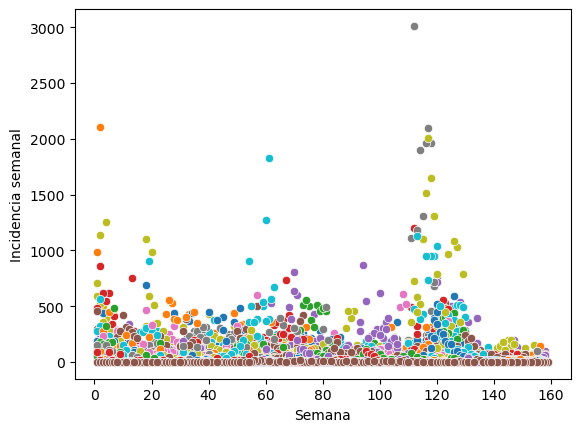

In [8]:
timeSeries = pd.DataFrame()

for dis in listaDistrito:
    distrito=df[df['Dep-Prov-Distrito']==dis]
    distrito.sort_values(['Semana'], ascending = True)    
    distrito = distrito.reset_index(drop=True)
    timeSeries = timeSeries.append(distrito['Incidencia semanal'])
    #timeSeriesNorm = timeSeriesNorm.append(pd.Series(normalizado.flatten()), ignore_index=True)
    #print(dis)
    ax = sns.scatterplot(y=distrito['Incidencia semanal'], x= distrito['Semana'])
plt.show()

In [9]:
timeSeries = timeSeries.fillna(0.00000000001)
timeSeries = timeSeries.replace('nan', np.nan).fillna(0.00000000001)
timeSeries = timeSeries.replace([np.inf, -np.inf], np.nan).fillna(0.00000000001)
lista_aux = timeSeries.values.tolist()

In [10]:
timeSeries.iloc[[1]].squeeze()

0      32.6122
1      65.2245
2      54.3537
3      65.2245
4      21.7415
        ...   
154     0.0000
155     0.0000
156     0.0000
157     0.0000
158     0.0000
Name: Incidencia semanal, Length: 159, dtype: float64

In [11]:
features = pd.DataFrame()
Mean=[]
Var=[]
aCF1=[]
Trend=[]
Linearity=[]
Curvature=[]
Season=[]
Peak=[]
Trough=[]
Entropy=[]
Lumpiness=[]
Spikiness=[]
Lshift=[]
Vchange=[]
Fspots=[]
Cpoints_=[]
Klscore=[]
ChangeIdx=[]
num = 0

for dis in listaDistrito:
    aux2 = timeSeries.iloc[[num]].squeeze()
    distrito_1 = df['Dep-Prov-Distrito']==dis
    casos_distrito1 = df[distrito_1]
    casos_distrito1 = casos_distrito1.reset_index(drop=True)
    casos_distrito1 = casos_distrito1['Incidencia semanal']
    casos_distrito1 = casos_distrito1.replace('nan', np.nan).fillna(0.00000000001)
    casos_distrito1 = casos_distrito1.replace(0, np.nan).fillna(0.00000000001)
    casos_distrito1 = casos_distrito1.replace([np.inf, -np.inf], np.nan).fillna(0.00000000001)
    #if (len(casos_distrito1)>8) :  
    #try:
    #Extracción
    model = TsFeatures()
    #aux = timeSeries.loc[[1]].T
    aux= casos_distrito1.to_frame()
    aux['time'] = aux.index
    aux = aux.rename(columns={"Incidencia semanal": "value"})
    aux = aux[['time', 'value']]
      
    output_features = model.transform(aux)
    mean = output_features['mean']
    var = output_features['var'] 
    ACF1 = output_features['y_acf1']
    trend = output_features['trend_strength']
    linear = output_features['linearity']
    curv = trend_seasonality_spike_strength(casos_distrito1, 4)['curvature']
    season = output_features['seasonality_strength']
    peak = output_features['peak']
    trough = output_features['trough']
    entropy = output_features['entropy']
    lump = output_features['lumpiness']
    spik = output_features['spikiness'] 
    lshift = output_features['level_shift_size']
    vchange = rolling_variance_change(casos_distrito1, 4)
    fspots = output_features['flat_spots']
    cpoints_ = output_features['crossing_points']
    try:
        klscore = kullback_leibler_score(aux2, 4)['score']
        changeidx = kullback_leibler_score(aux2, 4)['change_idx']
    except:
        klscore = np.nan
        changeidx = np.nan
    Mean.append(mean)
    Var.append(var)
    aCF1.append(ACF1)
    Trend.append(trend)
    Linearity.append(linear)
    Curvature.append(curv)
    Season.append(season)
    Peak.append(peak)
    Trough.append(trough)
    Entropy.append(entropy)
    Lumpiness.append(lump)
    Spikiness.append(spik)
    Lshift.append(lshift)
    Vchange.append(vchange)
    Fspots.append(fspots)
    Cpoints_.append(cpoints_)
    Klscore.append(klscore)
    ChangeIdx.append(changeidx)
    num = num + 1

ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features
ERROR:root:Length is shorter than period, or constant time series, unable to calculate acf/pacf features


In [12]:
data_tuples = list(zip(Mean, Var, aCF1, Trend, Linearity, Curvature, Season, Peak, Trough, Entropy, Lumpiness, Spikiness, Lshift, Vchange, Fspots, Cpoints_, Klscore, ChangeIdx))
features = pd.DataFrame(data_tuples, columns =['Mean', 'Var', 'ACF1','Trend', 'Linearity', 'Curvature', 'Season', 'Peak', 'Trough', 'Entropy', 'Lumpiness','Spikiness','Lshift', 'Vchange','Fspots', 'Cpoints', 'KlScore', 'ChangeIdx']) 

# print the data 
features

,Mean,Var,ACF1,Trend,Linearity,Curvature,Season,Peak,Trough,Entropy,Lumpiness,Spikiness,Lshift,Vchange,Fspots,Cpoints,KlScore,ChangeIdx
0,0.367223,7.012328,-0.000363,0.486359,0.055556,0.663508,0.670048,4,0,0.988549,9.773566e+01,0.013664,0.973140,94.700146,5,1,NaN,NaN
1,6.525471,200.220429,0.673212,0.708468,0.143647,-58.621023,0.412631,3,0,0.826581,5.295017e+04,1.131865,3.804760,1683.966820,15,9,NaN,NaN
2,0.078576,0.321089,-0.009889,0.413491,0.000021,-0.552311,0.679650,3,0,0.918866,1.941607e-01,0.000010,0.210234,4.419833,10,2,NaN,NaN
3,0.234384,2.856668,-0.000363,0.486359,0.055556,-0.423492,0.670048,0,1,0.988549,1.456840e+01,0.002268,0.621118,38.578759,5,0,NaN,NaN
4,0.220936,2.538259,-0.000363,0.486359,0.055556,-0.399193,0.670048,0,1,0.988549,1.150175e+01,0.001790,0.585480,34.278694,5,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,0.288589,4.330737,-0.000363,0.486359,0.055556,-0.521430,0.670048,0,1,0.988549,3.348233e+01,0.005212,0.764760,58.485765,5,0,NaN,NaN
392,5.879391,292.694282,0.735229,0.682321,0.002453,11.533549,0.325803,3,6,0.771956,1.163401e+05,3.494374,5.785698,3213.532657,15,5,NaN,NaN
393,8.385990,653.095239,0.708611,0.777719,0.071084,-69.290803,0.277425,2,5,0.766467,9.451546e+05,28.835886,10.209300,9195.444576,15,2,NaN,NaN
394,24.545722,6111.655226,0.457772,0.672731,0.010440,-77.238770,0.531630,0,5,0.839371,7.059457e+07,7025.136716,31.860500,83632.763411,10,5,NaN,NaN


In [13]:
features = features.replace('nan', np.nan).fillna(0.00000001)
features = features.replace(0, np.nan).fillna(0.0000001)
features = features.replace([np.inf, -np.inf], np.nan).fillna(0.00000001)
for col in features.columns:
    features[col] = features[col].astype(float)


features.insert(0, 'Dep-Prov-Distrito', listaDistrito)
features.to_csv('18Features_2015to2017.csv', index=False)
features = features.drop('Dep-Prov-Distrito', axis=1)

In [14]:
n= features.shape[0]

# Funciones de Distancias

In [15]:
import math
from math import sqrt, log, floor
from sklearn.metrics import mean_squared_error
from statistics import mean
from fastdtw import fastdtw
from scipy import stats
from scipy.spatial.distance import pdist

#Euclidean
def euclidean(x, y):
    r=np.linalg.norm(x-y)
    if math.isnan(r):
        r=1
    #print(r)
    return r

#Fast Dynamic time warping
def fast_DTW(x, y):
    r, _ = fastdtw(x, y, dist=euclidean)
    if math.isnan(r):
        r=1
    #print(r)
    return r

#Spearman
def scorr(x, y):
    r = stats.spearmanr(x, y)[0]
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

#RMSE
def rmse(x, y):
    r=sqrt(mean_squared_error(x,y))
    if math.isnan(r):
        r=1
    #print(r)
    return r

def lcs(a, b):  
    lengths = [[0 for j in range(len(b)+1)] for i in range(len(a)+1)]
    # row 0 and column 0 are initialized to 0 already
    for i, x in enumerate(a):
        for j, y in enumerate(b):
            if x == y:
                lengths[i+1][j+1] = lengths[i][j] + 1
            else:
                lengths[i+1][j+1] = max(lengths[i+1][j], lengths[i][j+1])
    x, y = len(a), len(b)
    result = lengths[x][y]
    return result

def discretise(x):
    return int(x * 10)

def multidim_lcs(a, b):
    a = a.applymap(discretise)
    b = b.applymap(discretise)
    rows, dims = a.shape
    lcss = [lcs(a[i+2], b[i+2]) for i in range(dims)]
    return 1 - sum(lcss) / (rows * dims)

#Correlation
def corr(x, y):
    r=np.dot(x-mean(x),y-mean(y))/((np.linalg.norm(x-mean(x)))*(np.linalg.norm(y-mean(y))))
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score

DIAMETER_METHODS = ['mean_cluster', 'farthest']
CLUSTER_DISTANCE_METHODS = ['nearest', 'farthest']

def inter_cluster_distances(labels, distances, method='nearest'):
    """Calculates the distances between the two nearest points of each cluster.
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: `nearest` for the distances between the two nearest points in each cluster, or `farthest`
    """
    if method not in CLUSTER_DISTANCE_METHODS:
        raise ValueError(
            'method must be one of {}'.format(CLUSTER_DISTANCE_METHODS))

    if method == 'nearest':
        return __cluster_distances_by_points(labels, distances)
    elif method == 'farthest':
        return __cluster_distances_by_points(labels, distances, farthest=True)


def __cluster_distances_by_points(labels, distances, farthest=False):
    n_unique_labels = len(np.unique(labels))
    cluster_distances = np.full((n_unique_labels, n_unique_labels),
                                float('inf') if not farthest else 0)

    np.fill_diagonal(cluster_distances, 0)

    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i, len(labels)):
            if labels[i] != labels[ii] and (
                (not farthest and
                 distances[i, ii] < cluster_distances[labels[i], labels[ii]])
                    or
                (farthest and
                 distances[i, ii] > cluster_distances[labels[i], labels[ii]])):
                cluster_distances[labels[i], labels[ii]] = cluster_distances[
                    labels[ii], labels[i]] = distances[i, ii]
    return cluster_distances


def diameter(labels, distances, method='farthest'):
    """Calculates cluster diameters
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: either `mean_cluster` for the mean distance between all elements in each cluster, or `farthest` for the distance between the two points furthest from each other
    """
    if method not in DIAMETER_METHODS:
        raise ValueError('method must be one of {}'.format(DIAMETER_METHODS))

    n_clusters = len(np.unique(labels))
    diameters = np.zeros(n_clusters)

    if method == 'mean_cluster':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii]:
                    diameters[labels[i]] += distances[i, ii]

        for i in range(len(diameters)):
            diameters[i] /= sum(labels == i)

    elif method == 'farthest':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii] and distances[i, ii] > diameters[
                        labels[i]]:
                    diameters[labels[i]] = distances[i, ii]
    return diameters

def dunn(labels, distances, diameter_method='farthest',
         cdist_method='nearest'):
    """
    Dunn index for cluster validation (larger is better).
    
    .. math:: D = \\min_{i = 1 \\ldots n_c; j = i + 1\ldots n_c} \\left\\lbrace \\frac{d \\left( c_i,c_j \\right)}{\\max_{k = 1 \\ldots n_c} \\left(diam \\left(c_k \\right) \\right)} \\right\\rbrace
    
    where :math:`d(c_i,c_j)` represents the distance between
    clusters :math:`c_i` and :math:`c_j`, and :math:`diam(c_k)` is the diameter of cluster :math:`c_k`.
    Inter-cluster distance can be defined in many ways, such as the distance between cluster centroids or between their closest elements. Cluster diameter can be defined as the mean distance between all elements in the cluster, between all elements to the cluster centroid, or as the distance between the two furthest elements.
    The higher the value of the resulting Dunn index, the better the clustering
    result is considered, since higher values indicate that clusters are
    compact (small :math:`diam(c_k)`) and far apart (large :math:`d \\left( c_i,c_j \\right)`).
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param diameter_method: see :py:function:`diameter` `method` parameter
    :param cdist_method: see :py:function:`diameter` `method` parameter
    
    .. [Kovacs2005] Kovács, F., Legány, C., & Babos, A. (2005). Cluster validity measurement techniques. 6th International Symposium of Hungarian Researchers on Computational Intelligence.
    """

    labels = LabelEncoder().fit(labels).transform(labels)
    
    

    ic_distances = inter_cluster_distances(labels, distances, cdist_method)
    #print("IC",ic_distances)
    if len(ic_distances[ic_distances.nonzero()])==0:
        min_distance = 0
    else:
        min_distance = min(ic_distances[ic_distances.nonzero()])
    max_diameter = max(diameter(labels, distances, diameter_method))
    
    

    return min_distance / max_diameter

In [17]:
features = features.replace('nan', np.nan).fillna(0.00001)

In [18]:
print('Existencia de nan: ', features.isnull().values.any()) 
#print('Cantidad de inf: ', np.isinf(features).values.sum() ) 

Existencia de nan:  False


In [19]:
import matplotlib.pyplot as plt
k=6

#Euclidean
f_euclidean_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(1,n):
         f_euclidean_dist[i,j] = euclidean(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())

#Corr
corr_dist = np.zeros((n,n))
for i in range(0,n):
    for j in range(0,n):
            corr_dist[i,j] = corr(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())

#scorr
f_scorr_dist = np.zeros((n,n))
for i in range(0,n):
    for j in range(0,n):
        f_scorr_dist[i,j] = scorr(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())
#DTW
f_dtw_dist = np.zeros((n,n))
for i in range(0,n):
    for j in range(0,n):
        f_dtw_dist[i,j] = fast_DTW(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())
    

In [20]:
#Experimentos HAC
HAC_EUCLIDEAN=[]
HAC_CORRELATION=[]
HAC_SPEARMAN=[]
HAC_DTW=[]

HAC_EUCLIDEAN_CHZ=[]
HAC_CORRELATION_CHZ=[]
HAC_SPEARMAN_CHZ=[]
HAC_DTW_CHZ=[]

HAC_EUCLIDEAN_DUNN=[]
HAC_CORRELATION_DUNN=[]
HAC_SPEARMAN_DUNN=[]
HAC_DTW_DUNN=[]

HAC_EUCLIDEAN_DAVID=[]
HAC_CORRELATION_DAVID=[]
HAC_SPEARMAN_DAVID=[]
HAC_DTW_DAVID=[]

HAC_euc = AgglomerativeClustering(n_clusters=k).fit_predict(f_euclidean_dist)
print("HAC + euclidian distance: ")
sil = silhouette_score(f_euclidean_dist, HAC_euc)
print("SC: ", sil)
chz = calinski_harabasz_score(f_euclidean_dist, HAC_euc)
print("CHZ: ", chz)
try:
    dunn_= dunn(HAC_euc, f_euclidean_dist, 'farthest', 'farthest')
except:
    dunn_= np.nan
print("DUNN: ", dunn_) 
david_= davies_bouldin_score(f_euclidean_dist, HAC_euc)
print("DAV-BOUD: ", david_)
HAC_EUCLIDEAN.append(sil)
HAC_EUCLIDEAN_CHZ.append(chz)
HAC_EUCLIDEAN_DUNN.append(dunn_)
HAC_EUCLIDEAN_DAVID.append(david_)

HAC_corr = AgglomerativeClustering(n_clusters=k).fit_predict(corr_dist)
print("HAC + corr distance: ")
sil = silhouette_score(corr_dist, HAC_corr)
print("SC: ", sil)
chz = calinski_harabasz_score(corr_dist, HAC_corr)
print("CHZ: ", chz)
try:
    dunn_ = dunn(HAC_corr, corr_dist, 'farthest', 'farthest')
except:
    dunn_= np.nan
print("DUNN: ", dunn_)
david_= davies_bouldin_score(corr_dist, HAC_corr)
print("DAV-BOUD: ", david_)
HAC_CORRELATION.append(sil)
HAC_CORRELATION_CHZ.append(chz)
HAC_CORRELATION_DUNN.append(dunn_)
HAC_CORRELATION_DAVID.append(david_)

HAC_scorr = AgglomerativeClustering(n_clusters=k).fit_predict(f_scorr_dist)
print("HAC + scorr distance: ")
sil = silhouette_score(f_scorr_dist, HAC_scorr)
print("SC: ", sil)
chz = calinski_harabasz_score(f_scorr_dist, HAC_scorr)
print("CHZ: ", chz)
try:
    dunn_ = dunn(HAC_scorr, f_scorr_dist, 'farthest', 'farthest')
except:
    dunn_= np.nan
print("DUNN: ", dunn_)
david_= davies_bouldin_score(f_scorr_dist, HAC_scorr)
print("DAV-BOUD: ", david_)
HAC_SPEARMAN.append(sil)
HAC_SPEARMAN_CHZ.append(chz)
HAC_SPEARMAN_DUNN.append(dunn_)
HAC_SPEARMAN_DAVID.append(david_)

HAC_dtw = AgglomerativeClustering(n_clusters=k).fit_predict(f_dtw_dist)
print("HAC + dtw distance: ")
sil = silhouette_score(f_dtw_dist, HAC_dtw)
print("SC: ", sil)
chz = calinski_harabasz_score(f_dtw_dist, HAC_dtw)
print("CHZ: ", chz)
try:
    dunn_ = dunn(HAC_dtw, f_dtw_dist, 'farthest', 'farthest')
except:
    dunn_= np.nan
print("DUNN: ", dunn_)
david_= davies_bouldin_score(f_dtw_dist, HAC_dtw)
print("DAV-BOUD: ", david_)
HAC_DTW.append(sil)
HAC_DTW_CHZ.append(chz)
HAC_DTW_DUNN.append(dunn_)
HAC_DTW_DAVID.append(david_)
print("-----------------------")

HAC + euclidian distance: 
SC:  0.9701698996687617
CHZ:  416769.0259279734
DUNN:  nan
DAV-BOUD:  0.25787659059617235
HAC + corr distance: 
SC:  0.7606420416528465
CHZ:  3655.501208511197
DUNN:  1.3747482853703368
DAV-BOUD:  0.5135542964714743
HAC + scorr distance: 
SC:  0.3935743065887979
CHZ:  366.2054907737428
DUNN:  1.3389656190282266
DAV-BOUD:  0.8742510410304454
HAC + dtw distance: 
SC:  0.9701549796282972
CHZ:  416947.20431773656
DUNN:  nan
DAV-BOUD:  0.2578349692314093
-----------------------


In [21]:
KM_EUCLIDEAN=[]
KM_CORRELATION=[]
KM_SPEARMAN=[]
KM_DTW=[]

KM_EUCLIDEAN_CHZ=[]
KM_CORRELATION_CHZ=[]
KM_SPEARMAN_CHZ=[]
KM_DTW_CHZ=[]

KM_EUCLIDEAN_DUNN=[]
KM_CORRELATION_DUNN=[]
KM_SPEARMAN_DUNN=[]
KM_DTW_DUNN=[]

KM_EUCLIDEAN_DAVID=[]
KM_CORRELATION_DAVID=[]
KM_SPEARMAN_DAVID=[]
KM_DTW_DAVID=[]
#Experimentos K-Means
km_euc = KMeans(n_clusters=k).fit_predict(f_euclidean_dist)
print("KM + euclidian distance: ")
sil = silhouette_score(f_euclidean_dist, km_euc)
print("SC: ", sil)
chz = calinski_harabasz_score(f_euclidean_dist, km_euc)
print("CHZ: ", chz)
try:
    dunn_ = dunn(km_euc, f_euclidean_dist, 'farthest', 'farthest')
except:
    dunn_= np.nan
print("DUNN: ", dunn_)
david_ = davies_bouldin_score(f_euclidean_dist, km_euc)
print("DAV-BOULD: ", david_)
KM_EUCLIDEAN.append(sil)
KM_EUCLIDEAN_CHZ.append(chz)
KM_EUCLIDEAN_DUNN.append(dunn_)
KM_EUCLIDEAN_DAVID.append(david_)

km_corr = KMeans(n_clusters=k).fit_predict(corr_dist)
print("KM + corr distance: ")
sil = silhouette_score(corr_dist, km_corr)
print("SC: ", sil)
chz = calinski_harabasz_score(corr_dist, km_corr)
print("CHZ: ", chz)
try:
    dunn_ = dunn(km_corr, corr_dist, 'farthest', 'farthest') 
except:
    dunn_= np.nan
print("DUNN: ", dunn_)
david_ = davies_bouldin_score(corr_dist, km_corr)
print("DAV-BOULD: ", david_)
KM_CORRELATION.append(sil)
KM_CORRELATION_CHZ.append(chz)
KM_CORRELATION_DUNN.append(dunn_)
KM_CORRELATION_DAVID.append(david_)

km_scorr = KMeans(n_clusters=k).fit_predict(f_scorr_dist)
print("KM + scorr distance: ")
sil = silhouette_score(f_scorr_dist, km_scorr)
print("SC: ", sil)
chz = calinski_harabasz_score(f_scorr_dist, km_scorr)
print("CHZ: ", chz)
try:
    dunn_ = dunn(km_scorr, f_scorr_dist, 'farthest', 'farthest')
except:
    dunn_= np.nan
print("DUNN: ", dunn_)
david_ = davies_bouldin_score(f_scorr_dist, km_scorr)
print("DAV-BOULD: ", david_)
KM_SPEARMAN.append(sil)
KM_SPEARMAN_CHZ.append(chz)
KM_SPEARMAN_DUNN.append(dunn_)
KM_SPEARMAN_DAVID.append(david_)

km_dtw = KMeans(n_clusters=k).fit_predict(f_dtw_dist)
print("KM + dtw distance: ")
sil = silhouette_score(f_dtw_dist, km_dtw)
print("SC: ", sil)
chz = calinski_harabasz_score(f_dtw_dist, km_dtw)
print("CHZ: ", chz)
try:
    dunn_ = dunn(km_dtw, f_dtw_dist, 'farthest', 'farthest')
except:
    dunn_= np.nan
print("DUNN: ", dunn_)
david_ = davies_bouldin_score(f_dtw_dist, km_dtw)
print("DAV-BOULD: ", david_)
KM_DTW.append(sil)
KM_DTW_CHZ.append(chz)
KM_DTW_DUNN.append(dunn_)
KM_DTW_DAVID.append(david_)
print("-----------------------")

KM + euclidian distance: 
SC:  0.9701698996687617
CHZ:  416769.0259279733
DUNN:  nan
DAV-BOULD:  0.25787659059617285
KM + corr distance: 
SC:  0.7452429967907236
CHZ:  3875.1318513434217
DUNN:  1.3747482853703368
DAV-BOULD:  0.5460872349870262
KM + scorr distance: 
SC:  0.4029221336146749
CHZ:  389.2116714333992
DUNN:  1.4548006730517296
DAV-BOULD:  0.9934270840486351
KM + dtw distance: 
SC:  0.9701549796282972
CHZ:  416947.2043177365
DUNN:  nan
DAV-BOULD:  0.25783496923140986
-----------------------


In [26]:
DBSCAN_EUCLIDEAN=[]
DBSCAN_CORRELATION=[]
DBSCAN_SPEARMAN=[]
DBSCAN_DTW=[]

DBSCAN_EUCLIDEAN_CHZ=[]
DBSCAN_CORRELATION_CHZ=[]
DBSCAN_SPEARMAN_CHZ=[]
DBSCAN_DTW_CHZ=[]

DBSCAN_EUCLIDEAN_DUNN=[]
DBSCAN_CORRELATION_DUNN=[]
DBSCAN_SPEARMAN_DUNN=[]
DBSCAN_DTW_DUNN=[]

DBSCAN_EUCLIDEAN_DAVID=[]
DBSCAN_CORRELATION_DAVID=[]
DBSCAN_SPEARMAN_DAVID=[]
DBSCAN_DTW_DAVID=[]

#CON EUCLIDEAN
DB_euc = DBSCAN(eps=10000, min_samples=3).fit_predict(f_euclidean_dist)
print("DBSCAN + euclidian distance: ")
sil =  silhouette_score(f_euclidean_dist, DB_euc)
CHZ_ = calinski_harabasz_score(f_euclidean_dist, DB_euc) 
try:
    dunn_ = dunn(DB_euc, f_euclidean_dist, 'farthest', 'farthest')
except:
    dunn_= np.nan
david_ = davies_bouldin_score(f_euclidean_dist, DB_euc)

print("SC: ", sil)
print("CHZ: ", CHZ_)
print("DUNN: ", dunn_)
print("DAV-BOULD: ", david_)

DBSCAN_EUCLIDEAN.append(sil)
DBSCAN_EUCLIDEAN_CHZ.append(CHZ_)
DBSCAN_EUCLIDEAN_DUNN.append(dunn_)
DBSCAN_EUCLIDEAN_DAVID.append(david_)

#CON CORRELATION
DB_corr = DBSCAN(eps=1.4, min_samples=3).fit_predict(corr_dist)
print("DBSCAN + corr distance: ")

sil = silhouette_score(corr_dist, DB_corr)
CHZ_ = calinski_harabasz_score(corr_dist, DB_corr)
try:
    dunn_ = dunn(DB_corr, corr_dist, 'farthest', 'farthest')
except:
    dunn_= np.nan
david_ = davies_bouldin_score(corr_dist, DB_corr)

print("SC: ", sil)
print("CHZ: ", CHZ_)
print("DUNN: ", dunn_)
print("DAV-BOULD: ", david_)

DBSCAN_CORRELATION.append(sil)
DBSCAN_CORRELATION_CHZ.append(CHZ_)
DBSCAN_CORRELATION_DUNN.append(dunn_)
DBSCAN_CORRELATION_DAVID.append(david_)

#CON SPEARMAN
DB_scorr = DBSCAN(eps=1.4, min_samples=3).fit_predict(f_scorr_dist)
print("DBSCAN + scorr distance: ")

sil = silhouette_score(f_scorr_dist, DB_scorr)
CHZ_ = calinski_harabasz_score(f_scorr_dist, DB_scorr)
try:
    dunn_ = dunn(DB_scorr, f_scorr_dist, 'farthest', 'farthest')
except:
    dunn_= np.nan
david_ = davies_bouldin_score(f_scorr_dist, DB_scorr)

print("SC: ", sil)
print("CHZ: ", CHZ_)
print("DUNN: ", dunn_)
print("DAV-BOULD: ", david_)
DBSCAN_SPEARMAN.append(sil)
DBSCAN_SPEARMAN_CHZ.append(CHZ_)
DBSCAN_SPEARMAN_DUNN.append(dunn_)
DBSCAN_SPEARMAN_DAVID.append(david_)

#CON D TIME WARPING
DB_dtw = DBSCAN(eps=100000, min_samples=3).fit_predict(f_dtw_dist)
print("DBSCAN + dtw distance: ")

sil = silhouette_score(f_dtw_dist, DB_dtw)
CHZ_ = calinski_harabasz_score(f_dtw_dist, DB_dtw)
try:
    dunn_ = dunn(DB_dtw, f_dtw_dist, 'farthest', 'farthest')
except:
    dunn_= np.nan
david_ = davies_bouldin_score(f_dtw_dist, DB_dtw)

print("SC: ", sil)
print("CHZ: ", CHZ_)
print("DUNN: ", dunn_)
print("DAV-BOULD: ", david_)

DBSCAN_DTW.append(sil)
DBSCAN_DTW_CHZ.append(CHZ_)
DBSCAN_DTW_DUNN.append(dunn_)
DBSCAN_DTW_DAVID.append(david_)

DBSCAN + euclidian distance: 
SC:  -0.073255777781844
CHZ:  0.29875668186725196
DUNN:  nan
DAV-BOULD:  1.8853705762576185
DBSCAN + corr distance: 
SC:  0.6911485773914641
CHZ:  982.0558871464141
DUNN:  0.8579214940656492
DAV-BOULD:  6.522911025751312
DBSCAN + scorr distance: 
SC:  0.44343876321844217
CHZ:  68.46964478292608
DUNN:  0.855919498013691
DAV-BOULD:  1.5126573783183164
DBSCAN + dtw distance: 
SC:  0.19305481634460733
CHZ:  0.3545856553294596
DUNN:  nan
DAV-BOULD:  1.8535272571330366


In [27]:
KM1 = KM_EUCLIDEAN + KM_CORRELATION + KM_SPEARMAN + KM_DTW
KM2 = KM_EUCLIDEAN_CHZ + KM_CORRELATION_CHZ + KM_SPEARMAN_CHZ + KM_DTW_CHZ
KM3 = KM_EUCLIDEAN_DUNN + KM_CORRELATION_DUNN + KM_SPEARMAN_DUNN + KM_DTW_DUNN
KM4 = KM_EUCLIDEAN_DAVID + KM_CORRELATION_DAVID + KM_SPEARMAN_DAVID + KM_DTW_DAVID
HAC1 = HAC_EUCLIDEAN + HAC_CORRELATION + HAC_SPEARMAN + HAC_DTW
HAC2 = HAC_EUCLIDEAN_CHZ + HAC_CORRELATION_CHZ + HAC_SPEARMAN_CHZ + HAC_DTW_CHZ
HAC3 = HAC_EUCLIDEAN_DUNN + HAC_CORRELATION_DUNN + HAC_SPEARMAN_DUNN + HAC_DTW_DUNN
HAC4 = HAC_EUCLIDEAN_DAVID + HAC_CORRELATION_DAVID + HAC_SPEARMAN_DAVID + HAC_DTW_DAVID
DBS1 = DBSCAN_EUCLIDEAN + DBSCAN_CORRELATION + DBSCAN_SPEARMAN + DBSCAN_DTW
DBS2 = DBSCAN_EUCLIDEAN_CHZ + DBSCAN_CORRELATION_CHZ + DBSCAN_SPEARMAN_CHZ + DBSCAN_DTW_CHZ
DBS3 = DBSCAN_EUCLIDEAN_DUNN + DBSCAN_CORRELATION_DUNN + DBSCAN_SPEARMAN_DUNN + DBSCAN_DTW_DUNN
DBS4 = DBSCAN_EUCLIDEAN_DAVID + DBSCAN_CORRELATION_DAVID + DBSCAN_SPEARMAN_DAVID + DBSCAN_DTW_DAVID

In [28]:
sil_scores = pd.DataFrame()
sil_scores['METRICA'] = ['Euclidean Distance', 'Pearson Correlation', 'Spearman Correlation', 'Dynamic Time Warping'] 
sil_scores['SIL - HAC'] = np.array(HAC1)
sil_scores['SIL - KM'] = np.array(KM1)
sil_scores['SIL - DB'] = np.array(DBS1)
sil_scores['CHZ - HAC'] = np.array(HAC2)
sil_scores['CHZ - KM'] = np.array(KM2)
sil_scores['CHZ - DB'] = np.array(DBS2)
sil_scores['DUNN - HAC'] = np.array(HAC3)
sil_scores['DUNN - KM'] = np.array(KM3)
sil_scores['DUNN - DB'] = np.array(DBS3)
sil_scores['DAVID - HAC'] = np.array(HAC4)
sil_scores['DAVID - KM'] = np.array(KM4)
sil_scores['DAVID - DB'] = np.array(DBS4)

In [29]:
sil_scores.to_csv('ScoresFB_2015to2017.csv')

In [30]:
aux2 = pd.DataFrame()
aux2['Distrito'] = listaDistrito
aux2['Cluster KM'] = km_euc
aux2['Cluster HAC '] = HAC_euc
aux2['Cluster DB SP'] = DB_corr
aux2.to_csv('ClusterFB_2015to2017.csv')

In [31]:
aux2

,Distrito,Cluster KM,Cluster HAC,Cluster DB SP
0,"AMAZONAS, BAGUA, ARAMANGO",0,4,0
1,"AMAZONAS, BAGUA, BAGUA",0,4,0
2,"AMAZONAS, BAGUA, IMAZA",0,4,1
3,"AMAZONAS, BAGUA, LA PECA",0,4,1
4,"AMAZONAS, BONGARA, FLORIDA",0,4,1
...,...,...,...,...
391,"UCAYALI, PADRE ABAD, ALEXANDER VON HUMBOLDT",0,4,1
392,"UCAYALI, PADRE ABAD, CURIMANA",0,4,0
393,"UCAYALI, PADRE ABAD, IRAZOLA",0,4,0
394,"UCAYALI, PADRE ABAD, NESHUYA",0,4,0


In [35]:
np.unique(DB_scorr)

array([-1,  0,  1,  2,  3,  4], dtype=int64)

In [33]:
np.unique(HAC_euc)

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [34]:
np.unique(km_euc)

array([0, 1, 2, 3, 4, 5])